<a href="https://colab.research.google.com/github/jnunez03/SQL/blob/master/CKAlerts_NonSubs_HitPaywall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Copy OF Cooking Alerts</h1>

<h3>Subscriptions</h3> 

- Number of users being served a pay wall 
- Conversion from pay wall
   - Using either DSSOR or Thank You Events
- % of non-sub regi’s who are served a pay wall (DoW)
- How many Starts were created? (by DoW)
   - Using DSSOR
   
   


In [2]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

#  Use ET2 From September Forward  -->  09/01 To [current date]
q = """
-- Paw Wall Impressions ET2
SELECT
day, 
dayName,
sum(users) as users,  
SUM(case when if_hit_paywall = 1 THEN users ELSE 0 END) as hitpaywall
FROM (
SELECT 
day,
format_datetime('%A',cast(day as datetime)) as dayName, 
UserType, 
if_hit_paywall, 
count(distinct user_id) as users
FROM (
SELECT 
day, 
user_id, 
if_hit_paywall, 
date_hit_paywall,
CASE
WHEN lower(curr_bundle_compatibility_group)  = 'ck' and day 
      between DATE(finance_paid_start_ts) and DATE(entitlement_end_ts) then 'Paid CK Sub'
WHEN (day between date(dssor.subscriber_start_ts) and date(dssor.subscriber_end_ts) 
  AND curr_promotion_market_speak = '4 Weeks Free' AND date(finance_paid_start_ts) IS NULL) THEN 'FT'
WHEN (day between date(dssor.subscriber_start_ts) and date(dssor.subscriber_end_ts)
  AND lower(curr_bundle_compatibility_group) = 'core' and curr_bundle_desc <> 'Basic Digital Access') then 
  'Core Entitled'
WHEN (day between date(dssor.subscriber_start_ts) and date(dssor.subscriber_end_ts)
  AND lower(curr_bundle_compatibility_group) = 'hd')  then 'HD Entitled'
ELSE 'non-sub'
END AS UserType
FROM(
        SELECT
        DATE(p.timestamps.last_updated_dt_nyct) as day,
        cast(p.json_kidd.user.regi_id as string) as user_id,
        MAX(CASE WHEN i.module.name LIKE '%paywall%' then 1 ELSE 0 END) as if_hit_paywall,
        MAX(CASE WHEN i.module.name LIKE '%paywall%' then i.dt_nyct ELSE NULL END) as date_hit_paywall
        FROM `nyt-eventtracker-prd.et.page` p   -- ET2 starts May 06
        LEFT JOIN p.impressions i
        WHERE DATE(p._pt) BETWEEN '2019-09-01' and '2019-10-30'
        AND LOWER(p.source_app) = 'nytcooking'
        and (p.agent.browser.is_spider is null or agent.browser.is_spider = false)
        GROUP BY 1,2
        ORDER BY 1,2 ASC
) p
JOIN `nyt-dssor-prd.dssor_chartio.subscriber_summary_chartio` dssor on p.user_id = cast(dssor.regi_id as string)
GROUP BY 1 , 2 , 3, 4, 5
)
where UserType = 'non-sub'
group by 1,2,3,4 
order by 1 asc 
LIMIT 118
)
group by 1,2
order by 1 asc
"""

# importing the data
df = pd.read_gbq(q,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')


# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=6))

INFO:google.auth.compute_engine._metadata:Compute Engine Metadata server unavailable.


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=FJHiGQpVuexrS3GhtCfvONrypDpCuL&prompt=consent&access_type=offline
Enter the authorization code: 4/sgFd2ctf6LCVkol17oKP5wIlmQM4cD7cn-roD6o2FlADy3hZ7_ugoA8
               users    hitpaywall
count      59.000000     59.000000
mean   181731.881356  19786.694915
std     47570.204653   6628.741133
min     91755.000000  10064.000000
25%    147988.500000  14487.000000
50%    184504.000000  18540.000000
75%    213915.500000  24359.000000
max    333484.000000  39744.000000  
 
 *Data Types Below* 
 
 day           datetime64[ns]
dayName               object
users                  int64
hitpaywall             int64
dtype: object  
 
          day    dayName   users  hitpaywall
0 2019-09-01   

In [6]:
pandas_profiling.ProfileReport(df)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,5
Number of observations,59
Total Missing (%),0.0%
Total size in memory,2.4 KiB
Average record size in memory,42.2 B
Numeric,3
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [3]:
# make sure date is of datetime. 
df['day'] = pd.to_datetime(df['day'])
 
df.dtypes   

day           datetime64[ns]
dayName               object
users                  int64
hitpaywall             int64
dtype: object

In [0]:
# Assuming our users is proper denominator. 

df['PercentHitWall'] = df.apply(lambda row: (row.hitpaywall / row.users) * 100, axis=1)     # -- >  axis=1 or ‘columns’: apply function to each row.

In [43]:
#df.head(n=59)    # index from 0
df.describe()

,users,hitpaywall,PercentHitWall
count,59.000000,59.000000,59.000000
mean,181731.881356,19786.694915,10.862680
std,47570.204653,6628.741133,2.085054
min,91755.000000,10064.000000,7.110244
25%,147988.500000,14487.000000,9.781909
50%,184504.000000,18540.000000,10.571986
75%,213915.500000,24359.000000,11.203645
max,333484.000000,39744.000000,18.494355


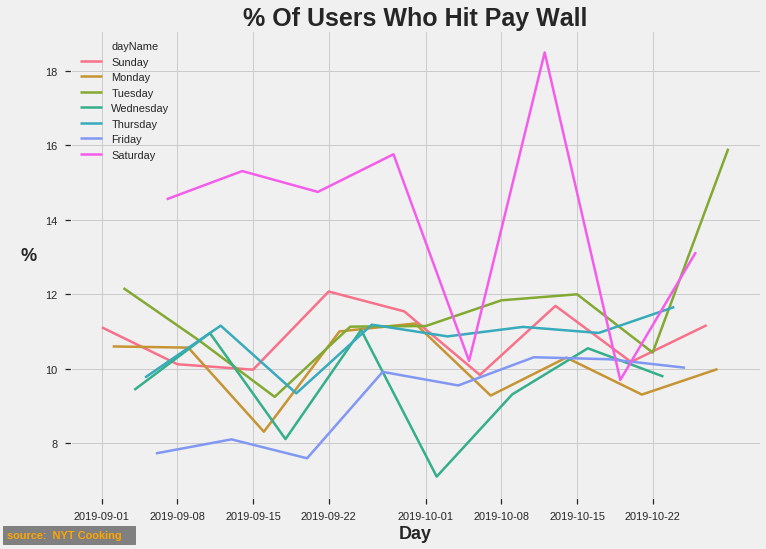

In [39]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
sb.lineplot(x="day", y="PercentHitWall", hue="dayName", data=df)   # Percent Hit WALL 
#sb.lineplot(x="day", y="hitpaywall", hue="dayName", data=df)   # Number Hit Wall 
plt.title('% Of Users Who Hit Pay Wall',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'source:  NYT Cooking   ', fontsize=11, color='Orange',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [0]:
dfMon = df[df['dayName'] == 'Monday']

dfTue = df[df['dayName'] == 'Tuesday']

dfWed = df[df['dayName'] == 'Wednesday']

dfThurs = df[df['dayName'] == 'Thursday']

dfFri =  df[df['dayName'] == 'Friday']

dfSat = df[df['dayName'] == 'Saturday']

dfSun = df[df['dayName'] == 'Sunday']

# Monday :) 


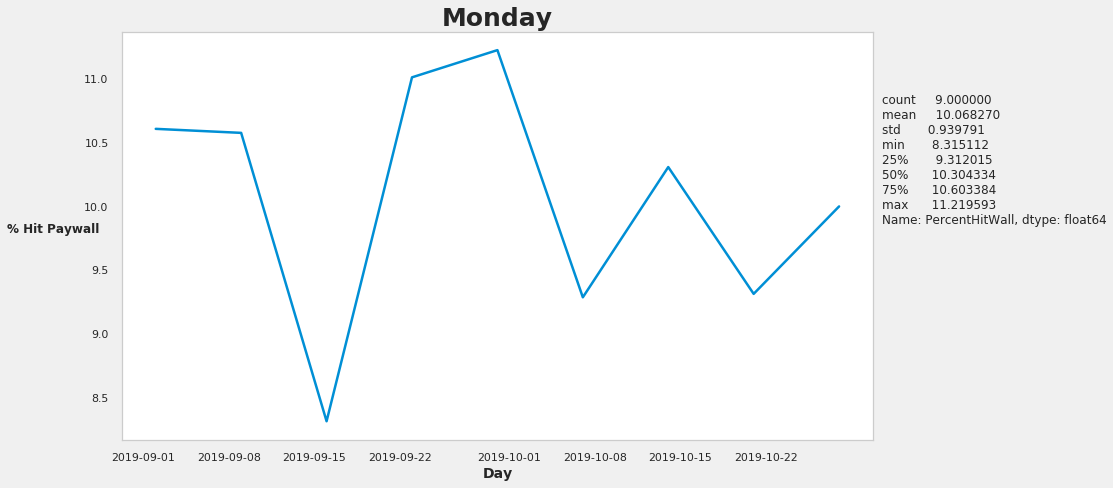

In [8]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfMon
mon = dfMon["PercentHitWall"].describe()
mon1 = str(mon)

#dfMon
sb.lineplot(x="day", y="PercentHitWall",markers=True, dashes=False, data=dfMon)
plt.title('Monday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall             ', fontsize=12, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,mon1)
plt.show()

<h1> Tuesday  :) <h1> 
  

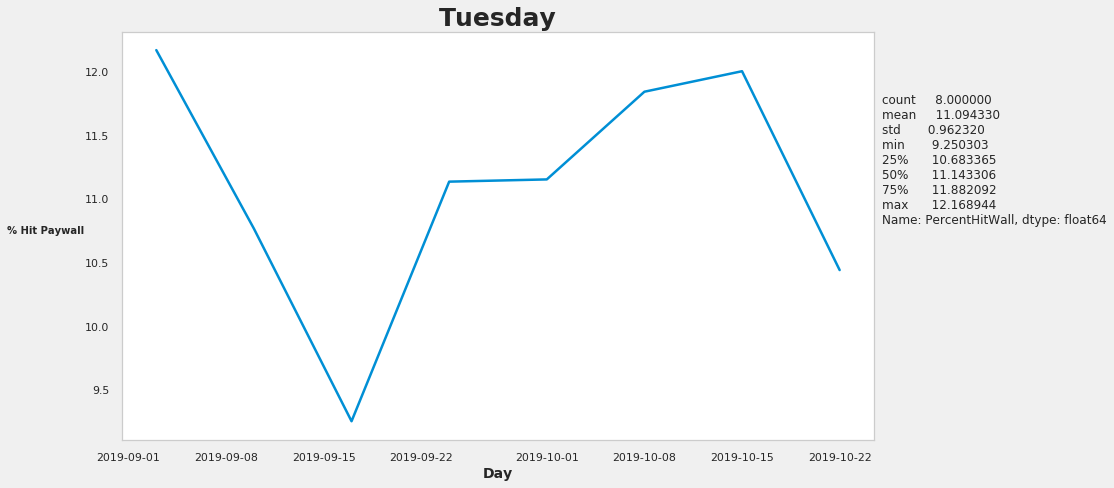

In [9]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfTue
Tue = dfTue["PercentHitWall"].describe()
Tue1= str(Tue)

#dfTue
sb.lineplot(x="day", y="PercentHitWall", data=dfTue)
plt.title('Tuesday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,Tue1)
plt.show()


<h1> Wednesday  :) <h1> 

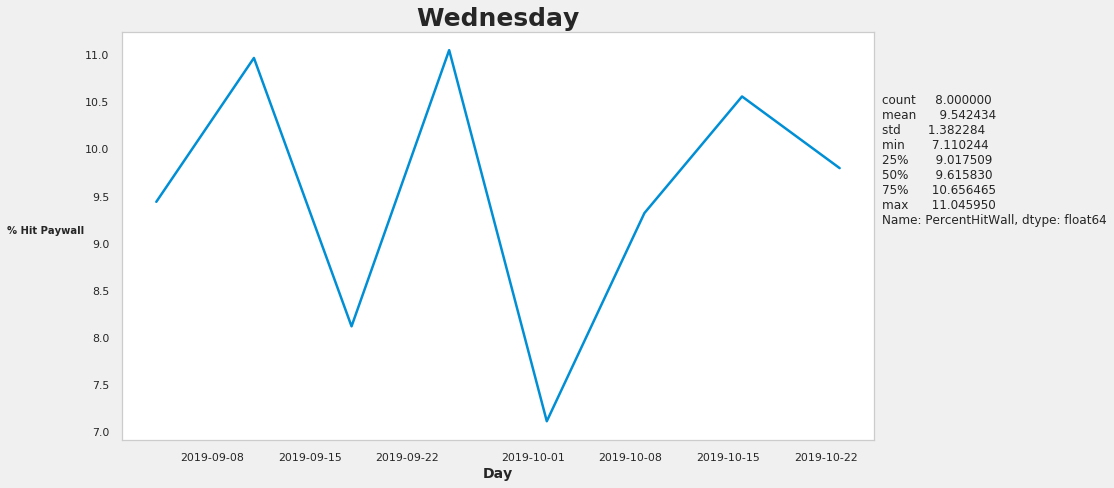

In [10]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfWed
wed = dfWed["PercentHitWall"].describe()
wed1 = str(wed)

#dfWed
sb.lineplot(x="day", y="PercentHitWall", data=dfWed)
plt.title('Wednesday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,wed1)
plt.show()

<h1> Thursday :) <h1> 

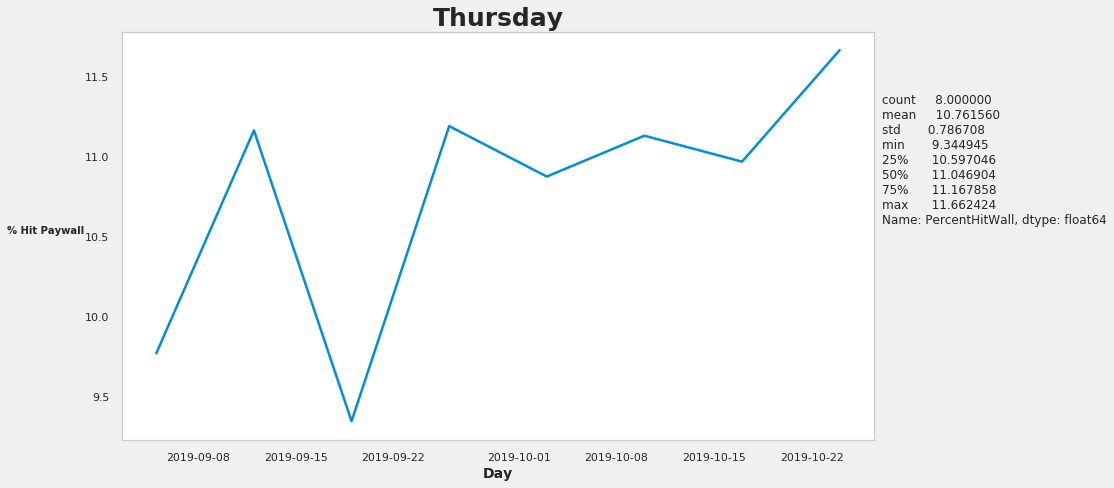

In [11]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfThurs
thurs = dfThurs["PercentHitWall"].describe()
thurs1 = str(thurs)

# dfThurs
sb.lineplot(x="day", y="PercentHitWall", data=dfThurs)
plt.title('Thursday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,thurs1)
plt.show()

<h1> Friday :) <h1> 

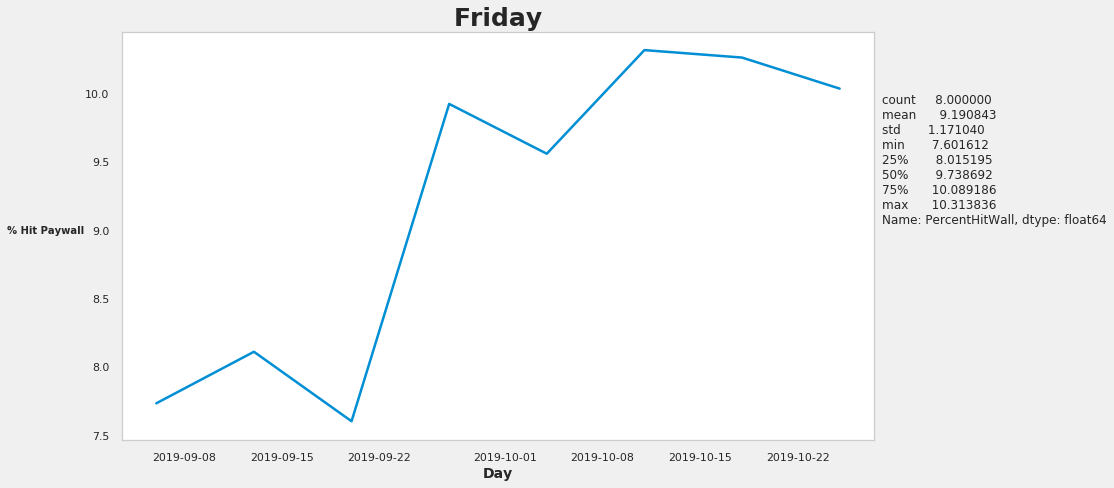

In [12]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfFri
fri = dfFri["PercentHitWall"].describe()
fri1 = str(fri)

# dfFri
sb.lineplot(x="day", y="PercentHitWall", data=dfFri)
plt.title('Friday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,fri1)
plt.show()

<h1> Saturday :) <h1> 

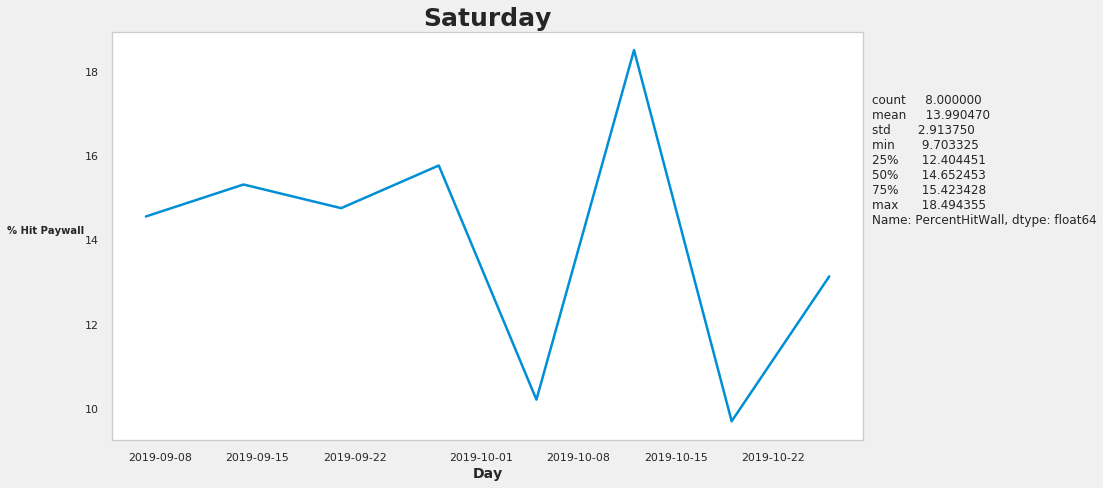

In [13]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSat
sat = dfSat["PercentHitWall"].describe()
sat1 = str(sat)

# dfSat
sb.lineplot(x="day", y="PercentHitWall", data=dfSat)
plt.title('Saturday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,sat1)
plt.show()

<h1> Sunday :) <h1> 

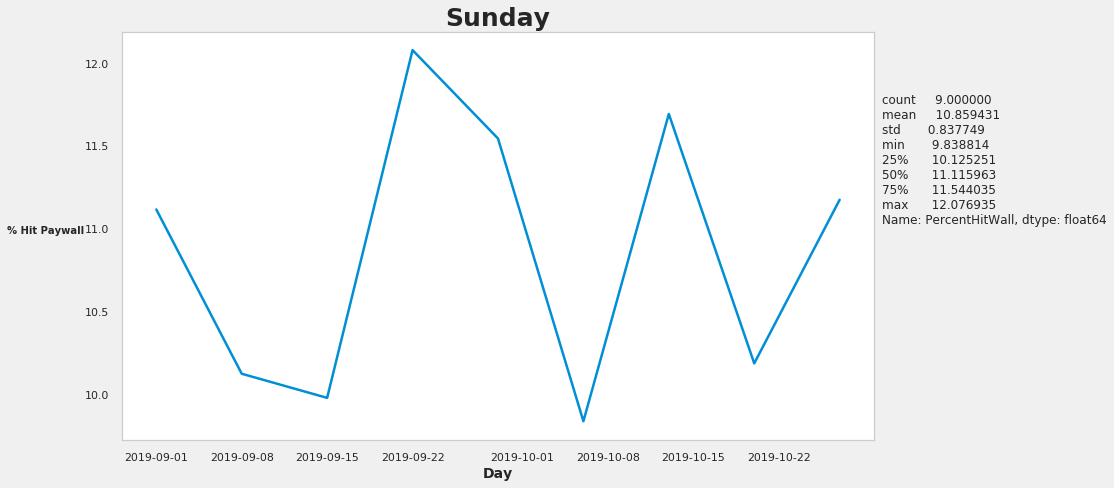

In [14]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSun
sun = dfSun["PercentHitWall"].describe()
sun1 = str(sun)

# dfSun
sb.lineplot(x="day", y="PercentHitWall", data=dfSun)
plt.title('Sunday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,sun1)
plt.show()

In [0]:
#dfMon = df[df['dayName'] == 'Monday']
#dfTue = df[df['dayName'] == 'Tuesday']
#dfWed = df[df['dayName'] == 'Wednesday']
#dfThurs = df[df['dayName'] == 'Thursday']
#dfFri =  df[df['dayName'] == 'Friday']
#dfSat = df[df['dayName'] == 'Saturday']
#df[df['dayName'] == 'Sunday']["PercentHitWall"].describe()
print("\n")
print(df[df['dayName'] == 'Sunday']["PercentHitWall"].mean())
print("\n")
print(np.std(df[df['dayName'] == 'Sunday']["PercentHitWall"]))

MondayAverage = np.mean(df[df['dayName'] == 'Monday']["PercentHitWall"])
MondaySD= np.std(df[df['dayName'] == 'Monday']["PercentHitWall"])
Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))



print(MondayAverage, 'std-->', MondaySD)
print('\n')
print(Mondaylow, '', MondayHigh)

In [0]:
def ThresholdForAlerts(df):
  # Take each df segment and print the mean % hit paywall and interval
  
  # Monday
  MondayAverage = np.mean(df[df['dayName'] == 'Monday']["PercentHitWall"])
  MondaySD= np.std(df[df['dayName'] == 'Monday']["PercentHitWall"])
  Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))
  minMon = df[df['dayName'] == 'Monday']["PercentHitWall"].min()

  
  # Tuesday
  TuesdayAverage = np.mean(df[df['dayName'] == 'Tuesday']["PercentHitWall"])
  TuesdaySD = np.std(df[df['dayName'] == 'Tuesday']["PercentHitWall"])
  Tuesdaylow, TuesdayHigh = ( TuesdayAverage - (2*(TuesdaySD)) ) , ( TuesdayAverage + (2*(TuesdaySD)))
  minTue = df[df['dayName'] == 'Tuesday']["PercentHitWall"].min()
  
  # Wednesday
  WedAverage = np.mean(df[df['dayName'] == 'Wednesday']["PercentHitWall"])
  WedSD = np.std(df[df['dayName'] == 'Wednesday']["PercentHitWall"]) 
  Wedlow, WedHigh = ( WedAverage - (2*(WedSD)) ) , ( WedAverage + (2*(WedSD)))
  minWed = df[df['dayName'] == 'Wednesday']["PercentHitWall"].min()
  
  # Thursday
  ThursAverage = np.mean(df[df['dayName'] == 'Thursday']["PercentHitWall"])
  ThursSD = np.std(df[df['dayName'] == 'Thursday']["PercentHitWall"])
  Thurslow, ThursHigh = ( ThursAverage - (2*(ThursSD)) ) , ( ThursAverage + (2*(ThursSD)))
  minThurs = df[df['dayName'] == 'Thursday']["PercentHitWall"].min()
  
  # Friday
  FriAverage = np.mean(df[df['dayName'] == 'Friday']["PercentHitWall"])
  FriSD = np.std(df[df['dayName'] == 'Friday']["PercentHitWall"])
  Frilow, FriHigh = ( FriAverage - (2*(FriSD)) ) , ( FriAverage + (2*(FriSD)))
  minFri = df[df['dayName'] == 'Friday']["PercentHitWall"].min()
  
  # Saturday
  SatAverage = np.mean(df[df['dayName'] == 'Saturday']["PercentHitWall"])
  SatSD = np.std(df[df['dayName'] == 'Saturday']["PercentHitWall"])
  Satlow, SatHigh = ( SatAverage - (2*(SatSD)) ) , ( SatAverage + (2*(SatSD)))
  minSat = df[df['dayName'] == 'Saturday']["PercentHitWall"].min()
  
  # Sunday
  SunAverage = np.mean(df[df['dayName'] == 'Sunday']["PercentHitWall"])
  SunSD = np.std(df[df['dayName'] == 'Sunday']["PercentHitWall"])
  Sunlow, SunHigh = ( SunAverage - (2*(SunSD)) ) , ( SunAverage + (2*(SunSD)))
  minSun = df[df['dayName'] == 'Sunday']["PercentHitWall"].min() 
  
   
  return(print(' Low: 2 Standard deviations below the Average', '\n',
               'High: 2 Standard deviations above the Average', ' \n ', 
            '\n', 
          '----------------------------------------------',
           '\n',
         'Monday Avg:', round(MondayAverage,3),
         '\n',
         'MondayLow - MondayHigh:', round(Mondaylow,3), '-', round(MondayHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Tuesday Avg:', round(TuesdayAverage,3),
         '\n',
         'TuesdayLow - TuesdayHigh:', round(Tuesdaylow,3), '-', round(TuesdayHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Wednesday Avg:', round(WedAverage,3),
         '\n',
         'WednesdayLow - WednesdayHigh:', round(Wedlow,3), '-', round(WedHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Thursday Avg:', round(ThursAverage,3),
         '\n',
         'ThursdayLow - ThursdayHigh:', round(Thurslow,3), '-', round(ThursHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Friday Avg:', round(FriAverage,3),
         '\n',
         'FridayLow - FridayHigh:', round(Frilow,3), '-', round(FriHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Saturday Avg:', round(SatAverage,3),
         '\n',
         'SatLow - SatHigh:', round(Satlow,3), '-', round(SatHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Sunday Avg:', round(SunAverage,3),
         '\n',
         'SunLow - SunHigh:', round(Sunlow,3), '-', round(SunHigh,3)
          ,
          '\n',
          '\n',
          '\n',
       '----------------------------------------------',
       '\n',
        'Monday min:', round(minMon,3),
          '\n',
       'Tuesday min:', round(minTue,3),
         '\n',
       'Wednesday min:', round(minWed,3),
         '\n',
       'Thursday min:', round(minThurs,3),
         '\n',
        'Friday min:', round(minFri,3),
         '\n',
        'Saturday min:', round(minSat,3),
         '\n',
       'Sunday min:', round(minSun,3)
        ))  

In [55]:
df[df['dayName'] == 'Monday']["PercentHitWall"].min()

8.315111637144176

In [68]:
ThresholdForAlerts(df)


 Low: 2 Standard deviations below the Average 
 High: 2 Standard deviations above the Average  
  
 ---------------------------------------------- 
 Monday Avg: 10.068 
 MondayLow - MondayHigh: 8.296 - 11.84 
 ---------------------------------------------- 
 Tuesday Avg: 11.63 
 TuesdayLow - TuesdayHigh: 8.158 - 15.101 
 ---------------------------------------------- 
 Wednesday Avg: 9.542 
 WednesdayLow - WednesdayHigh: 6.956 - 12.128 
 ---------------------------------------------- 
 Thursday Avg: 10.762 
 ThursdayLow - ThursdayHigh: 9.29 - 12.233 
 ---------------------------------------------- 
 Friday Avg: 9.191 
 FridayLow - FridayHigh: 7.0 - 11.382 
 ---------------------------------------------- 
 Saturday Avg: 13.99 
 SatLow - SatHigh: 8.539 - 19.442 
 ---------------------------------------------- 
 Sunday Avg: 10.859 
 SunLow - SunHigh: 9.28 - 12.439 
 
 
 ---------------------------------------------- 
 Monday min: 8.315 
 Tuesday min: 9.25 
 Wednesday min: 7.11 
 Thursday 

of users hitting a paywall, what is the page -- collection or recipes? 